In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from bbl_utils import *
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

In [13]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = -0.53e-4

In [14]:
dx = 500.
delta_t = 60.
diter = 28800

iter0 = 3182400
Niter = 22
dt = 1728000

iters = np.arange(iter0, iter0 + diter*Niter, diter)

In [15]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_rest-tracer/run/"
ds = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
ds1 = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["tracer01Diag"], delta_t=delta_t)
ds2 = open_mdsdataset(data_dir,iters=iters,ignore_unknown_vars=True,prefix=["tracer02Diag"], delta_t=delta_t)

ds_list = [ds, ds1, ds2]

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/xmitgcm/mds_store.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':


In [16]:
extend_multiples = [-1, 0]
xslice = [-3e5,3e5]

for i, d in enumerate(ds_list):
    Lx = d['XC'].size*dx
    d = periodic_extend(d, ['XC', 'XG'], Lx, extend_multiples)
    d = d.sel(XC=slice(*xslice), XG=slice(*xslice))
    H = ds['Depth'].max().values.copy().astype('>f8')
    d, grid = preprocess(d, θ)
    d['dV'] = (d.drF * d.rA * d.hFacC)
    ds_list[i] = d

In [17]:
ds = ds_list[0]; ds1 = ds_list[1]; ds2 = ds_list[2]
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['THETA_BG_U'] = Γ*ds['Zr_U']
ds['THETA_BG_V'] = Γ*ds['Zr_V']
ds['THETA_BG_W'] = Γ*ds['Zr_W']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

mask1 = ~(((((ds['θ'] <= 1.25) & (ds['XC'] <= -175e3)) | ((ds['θ'] >= 1.65) & (ds['XC'] >= 175e3)))).isel(time=0))
ds1['TRAC01'] = ds1['TRAC01'].where(mask1, 1.e-15)

mask2 = ~(((ds['θ'] <= 1.25) & (ds['XC'] <= -125e3)).isel(time=0))
ds2['TRAC02'] = ds2['TRAC02'].where(mask2, 1.e-15)

In [18]:
ds = ds_list[0]

TRAC01_xy = (ds1['TRAC01']*ds1['drF']).sum(dim='Z').isel(time=[0, 10 ,-1]).compute()
TRAC01_xy /= TRAC01_xy.max(dim=['XC', 'YC'])
TRAC01_xz = (ds1['TRAC01']*ds1['rA']).sum(dim='YC').isel(time=[0, 10, -1]).compute()
TRAC01_xz /= TRAC01_xz.max(dim=['XC', 'Z'])

TRAC02_xy = (ds2['TRAC02']*ds2['drF']).sum(dim='Z').isel(time=[0, 10, -1]).compute()
TRAC02_xy /= TRAC02_xy.max(dim=['XC', 'YC'])
TRAC02_xz = (ds2['TRAC02']*ds2['rA']).sum(dim='YC').isel(time=[0, 10, -1]).compute()
TRAC02_xz /= TRAC02_xz.max(dim=['XC', 'Z'])

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in a

In [19]:
for i, d in enumerate([ds1, ds2], start=1):
    d[f'M_TRAC0{i}'] = (d[f'TRAC0{i}']*d['dV']).sum(dim=['Z', 'YC', 'XC']).compute()
    d['Xbar'] = ((d['XC']*d[f'TRAC0{i}']*d['dV']).sum(dim=['Z', 'YC', 'XC']) / d[f'M_TRAC0{i}']).compute()
    d['Ybar'] = ((d['YC']*d[f'TRAC0{i}']*d['dV']).sum(dim=['Z', 'YC', 'XC']) / d[f'M_TRAC0{i}']).compute()
    d['Zbar'] = ((d['Z']*d[f'TRAC0{i}']*d['dV']).sum(dim=['Z', 'YC', 'XC']) / d[f'M_TRAC0{i}']).compute()
    d['θbar'] = ((ds['θ']*d[f'TRAC0{i}']*d['dV']).sum(dim=['Z', 'YC', 'XC']) / d[f'M_TRAC0{i}']).compute()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a i

In [20]:
δz = 40.
δx = 0.5e4
δy = 0.5e4
x1 = 3.e4; x2 = x1;
y1 = 3.e4; y2 = y1;

z1 = (H - ds1['Depth'].sel(XC = x1, YC = y1, method='nearest') + 900.).values
z2 = (H - ds2['Depth'].sel(XC = x2, YC = y2, method='nearest') + 150).values

C1 = np.exp(- ((ds1['XC'] - x1)/δx)**2 - ((ds1['YC'] - y1)/δx)**2 - ((ds1['Z'] - z1)/δz)**2)
C1 = C1.assign_coords({'Xr': ds1['Xr'], 'Zr': ds1['Zr']})
C1xy = (C1*ds1['drF']).sum(dim='Z')
C1xy = C1xy/C1xy.max()
C1xz = (C1*ds1['rA']).sum(dim='YC')
C1xz = C1xz/C1xz.max()

C2 = np.exp(- ((ds2['XC'] - x2)/δx)**2 - ((ds2['YC'] - y2)/δx)**2 - ((ds2['Z'] - z2)/δz)**2)
C2 = C2.assign_coords({'Xr': ds2['Xr'], 'Zr': ds2['Zr']})
C2xy = (C2*ds2['drF']).sum(dim='Z')
C2xy = C2xy/C2xy.max()
C2xz = (C2*ds2['rA']).sum(dim='YC')
C2xz = C2xz/C2xz.max()

/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/hdrake/.conda/envs/bblturb-analysis/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in less_equal
  return func(*(_execute_task(a, cache) for a in args))
/home/h

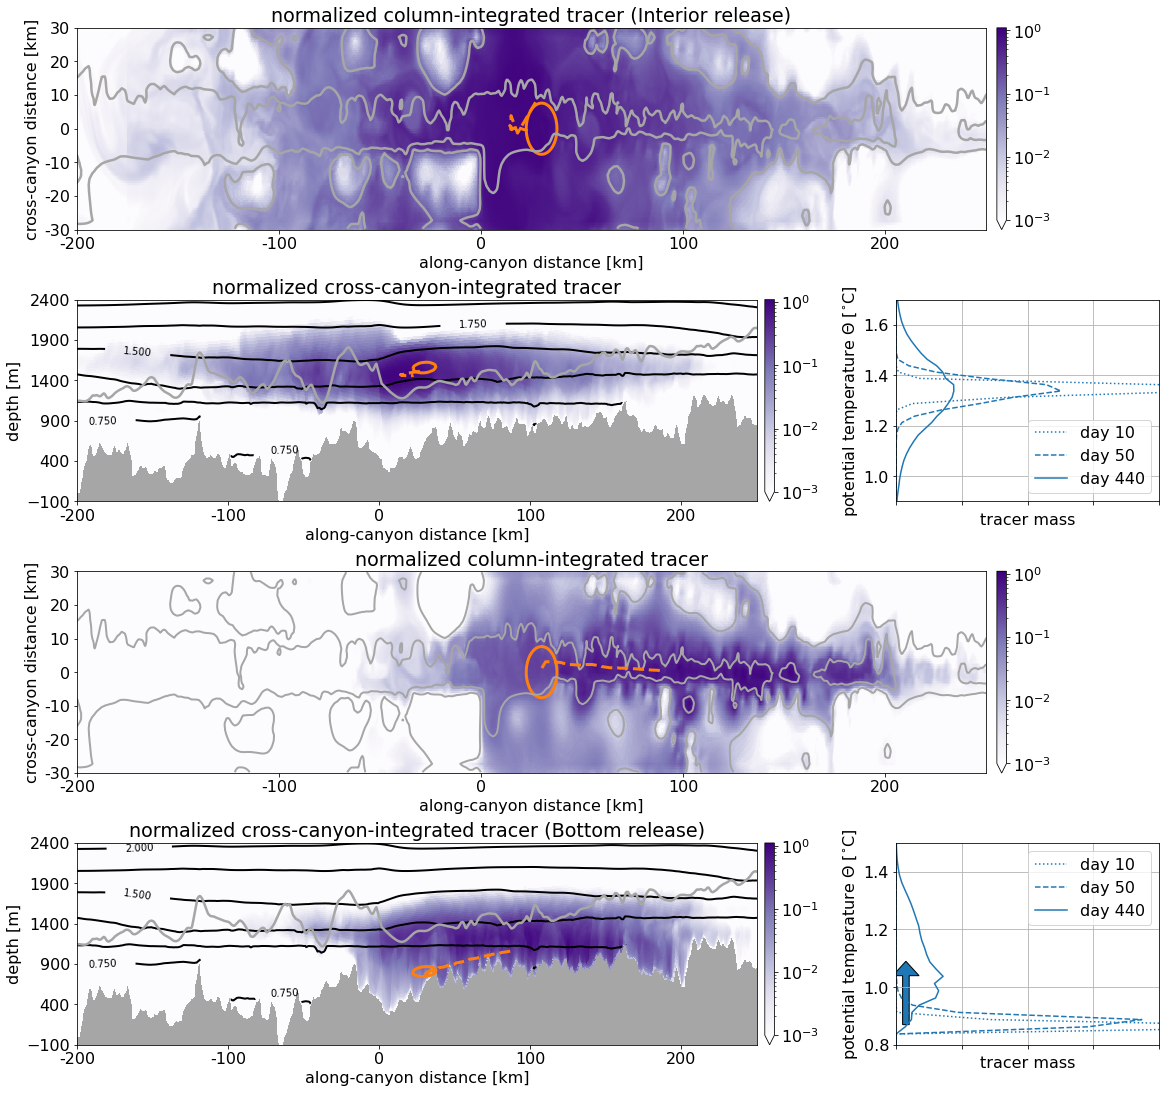

In [26]:
θlevels = np.arange(0.5, 2.5, 0.025)

ti = 2
xlims = [-2e5,2.5e5]
ylims1 = [500,2500]
ylims2 = [0,2250]

θlw = 2.
blw = 2.5
tlw = 3.0

linestyle = [":", "--", "-"]
tis = [0, 2, -1]
labels = [10, 50, 440]

ylim = [[0.9, 1.7], [0.8, 1.5]]

fig = plt.figure(figsize=(16,15))#, constrained_layout=True)
gs = fig.add_gridspec(4, 4)

f_ax1 = fig.add_subplot(gs[0, :])
tmap = plt.get_cmap("Purples")
tcolor = "C1"
θcolor = "k"
vmax = 1.1

q = TRAC01_xy.isel(time=ti).plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
C1xy.plot.contour(x='XC', y='YC', levels=[0.1], colors=tcolor, linewidths=tlw)
plt.plot(ds1['Xbar'], ds1['Ybar'], "--", color=tcolor, lw=tlw)
(H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = blw, levels=[1000, 1500])
plt.xlim(xlims)
plt.title("normalized column-integrated tracer (Interior release)")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon distance [km]")

f_ax2 = fig.add_subplot(gs[1, :-1], facecolor=nancol)
q = TRAC01_xz.isel(time=ti).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(ds1['Xbar'], ds1['Zbar'], "--", color=tcolor, lw=tlw)
(H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
C1xz.plot.contour(x='Xr', y='Zr', levels=[0.1], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=np.arange(0.5,2.5,0.25), linewidths=θlw)
f_ax2.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.xlim(xlims)
plt.ylim(ylims2)
plt.title("normalized cross-canyon-integrated tracer")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")

f_ax3 = fig.add_subplot(gs[1, -1])
for i, ti in enumerate(tis):
    h = histogram(ds['θ'].isel(time=ti), bins=[θlevels], weights=(ds1[f'TRAC01']*ds1['dV']).isel(time=ti))
    h.plot(y = "θ_bin", color="C0", linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[0])
    plt.ylabel(r"potential temperature $\Theta$ [$^{\circ}$C]")
    plt.xlabel("tracer mass")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.legend()

f_ax3.get_xaxis().set_ticklabels([])
plt.grid(True)
# width = 0.05e9; head_width = 0.2e9; head_length = 0.05;
# plt.arrow(
#     width*1.5, ds1['θbar'].isel(time=0).values, 0, (ds1['θbar'].isel(time=-1) - ds1['θbar'].isel(time=0)).values,
#     width=width, head_width=head_width, head_length=head_length, length_includes_head = True
# )

f_ax4 = fig.add_subplot(gs[2, :])
q = TRAC02_xy.isel(time=ti).plot(x='XC', y='YC', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
plt.plot(ds2['Xbar'], ds2['Ybar'], "--", color=tcolor, lw=tlw)
C2xy.plot.contour(x='XC', y='YC', levels=[0.1], colors=tcolor, linewidths=tlw)
(H-ds['Depthr']).plot.contour(colors=(nancol,), linewidths = 2., levels=[1000, 1500])
plt.xlim(xlims)
plt.title("normalized column-integrated tracer")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(0, 7e4, 1e4), np.arange(-30, 40, 10))
plt.ylabel("cross-canyon distance [km]")

f_ax5 = fig.add_subplot(gs[3, :-1], facecolor=nancol)
q = TRAC02_xz.isel(time=ti).plot(x='Xr', y='Zr', norm=matplotlib.colors.LogNorm(vmin=1.e-3, vmax=vmax), cmap=tmap)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, extend='min', label="")
(H-ds['Depthr']).isel(YC=np.append(np.arange(-15,0), np.arange(0,15))).mean(dim='YC').plot(color=nancol, lw=blw)
plt.ylim(0, 2500)
plt.plot(ds2['Xbar'], ds2['Zbar'], "--", color=tcolor, lw=tlw)
C2xz.plot.contour(x='Xr', y='Zr', levels=[0.1], colors=tcolor, linewidths=tlw)
CS = ds['θ'].mean(dim='YC').isel(time=0).plot.contour(x='Xr', y='Zr', colors="k", levels=np.arange(0.5,2.5,0.25), linewidths=θlw)
f_ax5.clabel(CS, inline=1, fontsize=10)
plt.title("")
plt.xlim(xlims)
plt.ylim(ylims2)
plt.title("normalized cross-canyon-integrated tracer (Bottom release)")
plt.xticks(np.arange(-2e5, 3e5, 1e5), np.arange(-200, 300, 100))
plt.xlabel("along-canyon distance [km]")
plt.yticks(np.arange(-100, 2500, 500))
plt.ylabel("depth [m]")

f_ax6 = fig.add_subplot(gs[3, -1])
for i, ti in enumerate(tis):
    h = histogram(ds['θ'].isel(time=ti), bins=[θlevels], weights=(ds2[f'TRAC02']*ds2['dV']).isel(time=ti))
    h.plot(y = "θ_bin", color="C0", linestyle=linestyle[i], label=f"day {labels[i]}")
    plt.ylim(ylim[1])
    plt.ylabel(r"potential temperature $\Theta$ [$^{\circ}$C]")
    plt.xlabel("tracer mass")
    plt.xlim([0,2e9])
    plt.xticks(labels=None)
plt.legend()
f_ax6.get_xaxis().set_ticklabels([])
plt.grid(True)
width = 0.05e9; head_width = 0.2e9; head_length = 0.05;
plt.arrow(
    width*1.5, ds2['θbar'].isel(time=0).values, 0, (ds2['θbar'].isel(time=-1) - ds2['θbar'].isel(time=0)).values,
    width=width, head_width=head_width, head_length=head_length, length_includes_head = True
)

plt.tight_layout(pad=0, h_pad=0.1)
plt.savefig("../../figures/BBTRE/tracer_spreading_440_days.png", dpi=100, bbox_inches="tight")